In [4]:
import numpy as np
import random
import torch
import torch.nn as nn            
import torch.optim as optim      
import torch.nn.functional as F  
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import glob
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from time import time
from matplotlib import rc

#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#number of epoch:
epoch = 3

In [5]:
class MNIST(Dataset):
    def __init__(self,
                 root,
                 transform=None,
                 preload=False):
        """ Intialize the MNIST dataset
        
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.images = None
        self.labels = None
        self.filenames = []
        self.root = root
        self.transform = transform

        # read filenames
        for i in range(10):
            filenames = glob.glob(osp.join(root, str(i), '*.png'))
            for fn in filenames:
                self.filenames.append((fn, i)) # (filename, label) pair
                
        # if preload dataset into memory
        if preload:
            self._preload()
            
        self.len = len(self.filenames)
                              
    def _preload(self):
        self.labels = []
        self.images = []
        for image_fn, label in self.filenames:            
            # load images
            image = Image.open(image_fn)
            self.images.append(image.copy())
            # avoid too many opened files bug
            image.close()
            self.labels.append(label)

    # probably the most important to customize.
    def __getitem__(self, index):
        if self.images is not None:
            # If dataset is preloaded
            image = self.images[index]
            label = self.labels[index]
        else:
            # If on-demand data loading
            image_fn, label = self.filenames[index]
            image = Image.open(image_fn)
            
        if self.transform is not None:
            image = self.transform(image)
        # return image and label
        return image, label

    def __len__(self):
        return self.len #Total number of samples in the dataset

In [6]:
# Load the training set:
trainset = MNIST(
    root='mnist_png/training',
    preload=True, transform=transforms.ToTensor(),
)

trainset_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=1)

# Load the testset:
testset = MNIST(
    root='mnist_png/testing',
    preload=True, transform=transforms.ToTensor(),
)

testset_loader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=1)

In [7]:
#check
print(len(trainset)) # len = 60000
print(len(testset))  # len = 10000

60000
10000


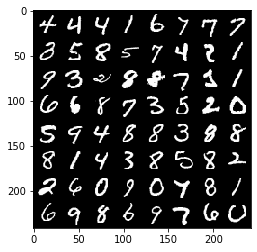

In [8]:
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainset_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# 1. SoftMax + Cross Entropy Loss


## $L_1$ regularization on the last layer:

In [113]:
#create an array of regularization parameters from 0 to 0.03 with step size 0.001
reg_params = np.linspace(0, 0.03, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_L1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L1 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_nr_L1 = []

In [114]:
#define a function to compute average loss and accuracy rate
def result_CELoss(loader):
    model.eval()
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            sum_loss += F.cross_entropy(output, target, reduction='sum').item()
            correct += pred.eq(target.view_as(pred)).sum().item()
    return (sum_loss/len(loader.dataset)), (100. * correct / len(loader.dataset)), correct, len(loader.dataset) 

In [115]:
for reg_param in reg_params:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (no reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #compute loss
            loss = F.cross_entropy(output, target) + reg_param*l1_norm
            a_list.append(loss.item())
            b_list.append(F.cross_entropy(output, target).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_CELoss(trainset_loader)
    result_test = result_CELoss(testset_loader)
    train_ave_loss_L1.append(result_train[0])
    test_ave_loss_L1.append(result_test[0])
    train_acc_L1.append(result_train[1])
    test_acc_L1.append(result_test[1])
    matrix_norm_L1.append(torch.norm(model.fc_layers[-1].weight.detach(), p=1))
    listoflist_L1.append(list(a_list))
    listoflist_nr_L1.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297990
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.294003
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.284033
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.252434
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.161397
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.837699
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.030526
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.404566
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.228524
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.421691
26.55s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.325630
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.279891
Regularization pa

Regularization parameter: 0.003 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.510113
Regularization parameter: 0.003 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.670118
Regularization parameter: 0.003 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.549065
Regularization parameter: 0.003 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.341078
Regularization parameter: 0.003 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.583483
Regularization parameter: 0.003 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.558251
Regularization parameter: 0.003 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.301625
Regularization parameter: 0.003 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.386442
27.05s
Regularization parameter: 0.003 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.375942
Regularization parameter: 0.003 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.527351
Regularization parameter: 0.003 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.287049
Regularization parameter: 0.003 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.350540
Regularizati

Regularization parameter: 0.006 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.402940
Regularization parameter: 0.006 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.295172
Regularization parameter: 0.006 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.346861
Regularization parameter: 0.006 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.396009
Regularization parameter: 0.006 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.282690
Regularization parameter: 0.006 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.541805
Regularization parameter: 0.006 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.407238
28.32s

Test set: Average loss: 0.2122, Accuracy: 9399/10000 (94%)

Regularization parameter: 0.007 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.909766
Regularization parameter: 0.007 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.780588
Regularization parameter: 0.007 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.655260
Regularization parameter: 0.007 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.548175
Regularization parameter: 0.007 Trai

Regularization parameter: 0.010 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.514871
Regularization parameter: 0.010 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.389286
Regularization parameter: 0.010 Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.333076
Regularization parameter: 0.010 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.312840
Regularization parameter: 0.010 Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.300706
Regularization parameter: 0.010 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.303015
Regularization parameter: 0.010 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.298459
26.23s
Regularization parameter: 0.010 Train Epoch: 2 [3968/60000 (7%)]	Loss: 2.299180
Regularization parameter: 0.010 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.304202
Regularization parameter: 0.010 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.301516
Regularization parameter: 0.010 Train Epoch: 2 [23168/60000 (39%)]	Loss: 2.293396
Regularization parameter: 0.010 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.308144
Regularizat

Regularization parameter: 0.013 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.312673
Regularization parameter: 0.013 Train Epoch: 2 [35968/60000 (60%)]	Loss: 2.308702
Regularization parameter: 0.013 Train Epoch: 2 [42368/60000 (71%)]	Loss: 2.311325
Regularization parameter: 0.013 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.312063
Regularization parameter: 0.013 Train Epoch: 2 [55168/60000 (92%)]	Loss: 2.310384
33.31s
Regularization parameter: 0.013 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.300008
Regularization parameter: 0.013 Train Epoch: 3 [7936/60000 (13%)]	Loss: 2.305713
Regularization parameter: 0.013 Train Epoch: 3 [14336/60000 (24%)]	Loss: 2.300027
Regularization parameter: 0.013 Train Epoch: 3 [20736/60000 (35%)]	Loss: 2.298712
Regularization parameter: 0.013 Train Epoch: 3 [27136/60000 (45%)]	Loss: 2.308838
Regularization parameter: 0.013 Train Epoch: 3 [33536/60000 (56%)]	Loss: 2.300846
Regularization parameter: 0.013 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.311591
Regularizati

Regularization parameter: 0.016 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.311881
Regularization parameter: 0.016 Train Epoch: 3 [46336/60000 (77%)]	Loss: 2.313087
Regularization parameter: 0.016 Train Epoch: 3 [52736/60000 (88%)]	Loss: 2.304452
Regularization parameter: 0.016 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.303805
26.19s

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Regularization parameter: 0.017 Train Epoch: 1 [0/60000 (0%)]	Loss: 3.783732
Regularization parameter: 0.017 Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.096390
Regularization parameter: 0.017 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.585020
Regularization parameter: 0.017 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.343736
Regularization parameter: 0.017 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.298946
Regularization parameter: 0.017 Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.306497
Regularization parameter: 0.017 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.308438
Regularization parameter: 0.017 Trai

Regularization parameter: 0.020 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.308897
Regularization parameter: 0.020 Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.301013
Regularization parameter: 0.020 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.305023
Regularization parameter: 0.020 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.300253
28.30s
Regularization parameter: 0.020 Train Epoch: 2 [3968/60000 (7%)]	Loss: 2.300373
Regularization parameter: 0.020 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.307054
Regularization parameter: 0.020 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.304997
Regularization parameter: 0.020 Train Epoch: 2 [23168/60000 (39%)]	Loss: 2.295118
Regularization parameter: 0.020 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.313517
Regularization parameter: 0.020 Train Epoch: 2 [35968/60000 (60%)]	Loss: 2.309553
Regularization parameter: 0.020 Train Epoch: 2 [42368/60000 (71%)]	Loss: 2.312180
Regularization parameter: 0.020 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.312884
Regularizat

Regularization parameter: 0.023 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.313348
Regularization parameter: 0.023 Train Epoch: 2 [55168/60000 (92%)]	Loss: 2.311631
26.32s
Regularization parameter: 0.023 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.301270
Regularization parameter: 0.023 Train Epoch: 3 [7936/60000 (13%)]	Loss: 2.307095
Regularization parameter: 0.023 Train Epoch: 3 [14336/60000 (24%)]	Loss: 2.301294
Regularization parameter: 0.023 Train Epoch: 3 [20736/60000 (35%)]	Loss: 2.300011
Regularization parameter: 0.023 Train Epoch: 3 [27136/60000 (45%)]	Loss: 2.310117
Regularization parameter: 0.023 Train Epoch: 3 [33536/60000 (56%)]	Loss: 2.302147
Regularization parameter: 0.023 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.312936
Regularization parameter: 0.023 Train Epoch: 3 [46336/60000 (77%)]	Loss: 2.314061
Regularization parameter: 0.023 Train Epoch: 3 [52736/60000 (88%)]	Loss: 2.305407
Regularization parameter: 0.023 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.304787
26.06s

Test

Regularization parameter: 0.026 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.305276
25.30s

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Regularization parameter: 0.027 Train Epoch: 1 [0/60000 (0%)]	Loss: 4.657698
Regularization parameter: 0.027 Train Epoch: 1 [6400/60000 (11%)]	Loss: 3.079517
Regularization parameter: 0.027 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.337972
Regularization parameter: 0.027 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.310221
Regularization parameter: 0.027 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.300371
Regularization parameter: 0.027 Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.308037
Regularization parameter: 0.027 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.310193
Regularization parameter: 0.027 Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.302229
Regularization parameter: 0.027 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.306332
Regularization parameter: 0.027 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.301494
26.79s
Regularization parameter: 0.0

Regularization parameter: 0.030 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.302122
26.35s
Regularization parameter: 0.030 Train Epoch: 2 [3968/60000 (7%)]	Loss: 2.302186
Regularization parameter: 0.030 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.308904
Regularization parameter: 0.030 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.306907
Regularization parameter: 0.030 Train Epoch: 2 [23168/60000 (39%)]	Loss: 2.296966
Regularization parameter: 0.030 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.315375
Regularization parameter: 0.030 Train Epoch: 2 [35968/60000 (60%)]	Loss: 2.311466
Regularization parameter: 0.030 Train Epoch: 2 [42368/60000 (71%)]	Loss: 2.314048
Regularization parameter: 0.030 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.314715
Regularization parameter: 0.030 Train Epoch: 2 [55168/60000 (92%)]	Loss: 2.313002
25.89s
Regularization parameter: 0.030 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.302638
Regularization parameter: 0.030 Train Epoch: 3 [7936/60000 (13%)]	Loss: 2.308450
Regular

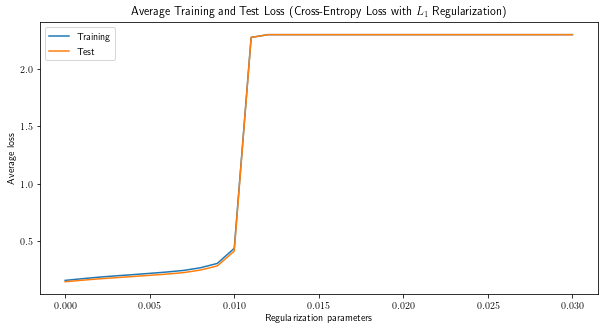

In [116]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Cross-Entropy Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params, train_ave_loss_L1, label="Training")
plt.plot(reg_params, test_ave_loss_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

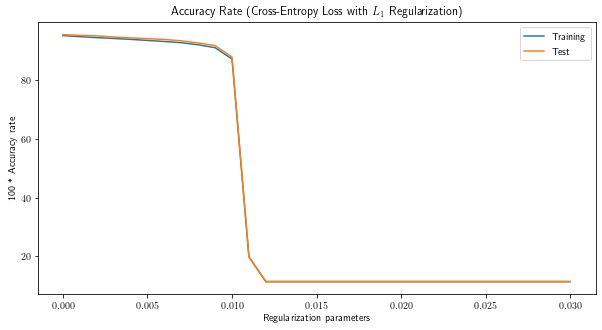

In [117]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Cross-Entropy Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params, train_acc_L1, label="Training")
plt.plot(reg_params, test_acc_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

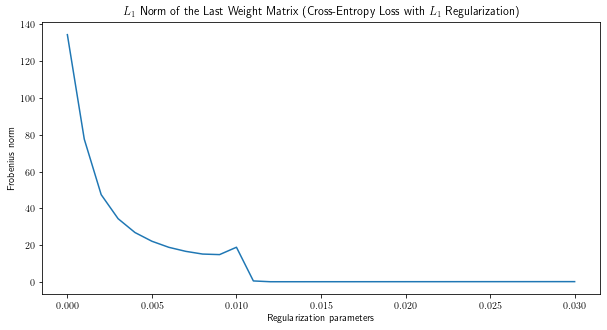

In [143]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"$L_1$ Norm of the Last Weight Matrix (Cross-Entropy Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params, matrix_norm_L1)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

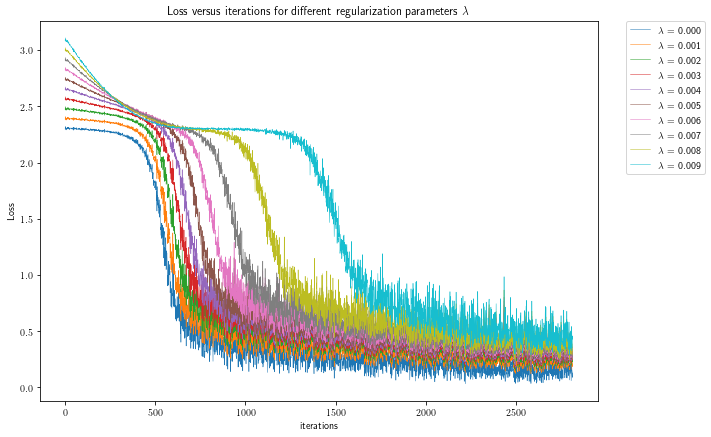

In [153]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_L1)-21):
    plt.plot(listoflist_L1[i], label=r"$\lambda$ = {:.3f}".format(reg_params[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

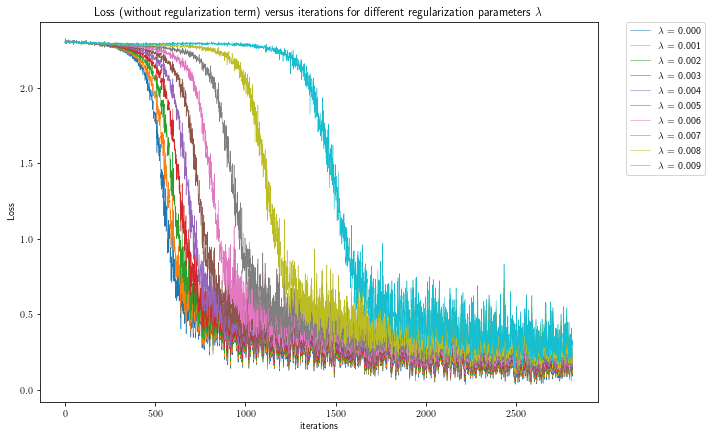

In [154]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_nr_L1)-21):
    plt.plot(listoflist_nr_L1[i], label=r"$\lambda$ = {:.3f}".format(reg_params[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## $L_2$ regularization on the last layer:

In [123]:
#create an array of regularization parameters from 0 to 2 with step size 0.1
reg_params2 = np.linspace(0, 2, num=21, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_L2 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_L2 = []

#initiate a list storing training accuracy for different reg_param
train_acc_L2 = []

#initiate a list storing test accuracy for different reg_param
test_acc_L2 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_L2 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_nr_L2 = []

In [124]:
for reg_param in reg_params2:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (w/o reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L2 norm of weight matrix on the last layer 
            l2_norm = torch.norm(model.fc_layers[-1].weight)**2
            
            #compute loss
            loss = F.cross_entropy(output, target) + reg_param*l2_norm
            a_list.append(loss.item())
            b_list.append(F.cross_entropy(output, target).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_CELoss(trainset_loader)
    result_test = result_CELoss(testset_loader)
    train_ave_loss_L2.append(result_train[0])
    test_ave_loss_L2.append(result_test[0])
    train_acc_L2.append(result_train[1])
    test_acc_L2.append(result_test[1])
    matrix_norm_L2.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_L2.append(list(a_list))
    listoflist_nr_L2.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297990
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.294003
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.284033
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.252434
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.161397
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.837699
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.030526
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.404566
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.228524
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.421691
26.74s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.325630
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.279891
Regularization pa

Regularization parameter: 0.300 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.202018
Regularization parameter: 0.300 Train Epoch: 2 [16768/60000 (28%)]	Loss: 1.978767
Regularization parameter: 0.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 1.509299
Regularization parameter: 0.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.863318
Regularization parameter: 0.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 1.010421
Regularization parameter: 0.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.859643
Regularization parameter: 0.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.578386
Regularization parameter: 0.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.661074
25.88s
Regularization parameter: 0.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.590278
Regularization parameter: 0.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.622374
Regularization parameter: 0.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.499820
Regularization parameter: 0.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.605227
Regularizati

Regularization parameter: 0.600 Train Epoch: 3 [20736/60000 (35%)]	Loss: 1.193273
Regularization parameter: 0.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.809653
Regularization parameter: 0.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.792362
Regularization parameter: 0.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.793775
Regularization parameter: 0.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.624269
Regularization parameter: 0.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.848333
Regularization parameter: 0.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.671856
26.57s

Test set: Average loss: 0.4223, Accuracy: 8861/10000 (89%)

Regularization parameter: 0.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 4.652193
Regularization parameter: 0.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.424998
Regularization parameter: 0.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.305697
Regularization parameter: 0.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.306219
Regularization parameter: 0.700 Trai

Regularization parameter: 1.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.306506
Regularization parameter: 1.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.297010
Regularization parameter: 1.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.304676
Regularization parameter: 1.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.306971
Regularization parameter: 1.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.298508
Regularization parameter: 1.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.302687
Regularization parameter: 1.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.298308
26.27s
Regularization parameter: 1.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 2.297825
Regularization parameter: 1.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.304169
Regularization parameter: 1.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.302052
Regularization parameter: 1.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 2.292925
Regularization parameter: 1.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.309920
Regularizat

Regularization parameter: 1.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.310894
Regularization parameter: 1.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 2.307131
Regularization parameter: 1.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 2.309588
Regularization parameter: 1.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.309799
Regularization parameter: 1.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 2.308473
27.06s
Regularization parameter: 1.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.298470
Regularization parameter: 1.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 2.303705
Regularization parameter: 1.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 2.298212
Regularization parameter: 1.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 2.297110
Regularization parameter: 1.300 Train Epoch: 3 [27136/60000 (45%)]	Loss: 2.305674
Regularization parameter: 1.300 Train Epoch: 3 [33536/60000 (56%)]	Loss: 2.297528
Regularization parameter: 1.300 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.307896
Regularizati

Regularization parameter: 1.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.309470
Regularization parameter: 1.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 2.310180
Regularization parameter: 1.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 2.302415
Regularization parameter: 1.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.300935
26.65s

Test set: Average loss: 2.2977, Accuracy: 1135/10000 (11%)

Regularization parameter: 1.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.015341
Regularization parameter: 1.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.299405
Regularization parameter: 1.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.301630
Regularization parameter: 1.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.306916
Regularization parameter: 1.700 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.297292
Regularization parameter: 1.700 Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.304937
Regularization parameter: 1.700 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.307271
Regularization parameter: 1.700 Trai

Regularization parameter: 2.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.307329
Regularization parameter: 2.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.299147
Regularization parameter: 2.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.303314
Regularization parameter: 2.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.298659
26.67s
Regularization parameter: 2.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 2.298519
Regularization parameter: 2.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 2.305162
Regularization parameter: 2.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.303159
Regularization parameter: 2.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 2.293357
Regularization parameter: 2.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 2.311557
Regularization parameter: 2.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 2.307657
Regularization parameter: 2.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 2.310235
Regularization parameter: 2.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 2.310758
Regularizat

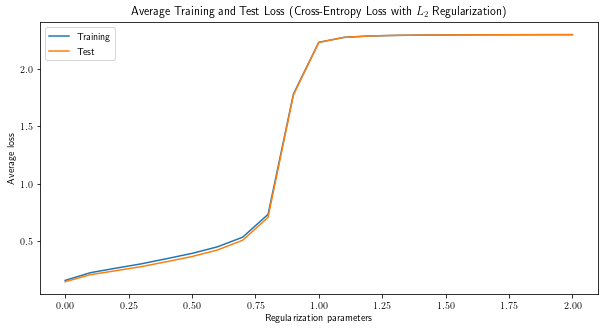

In [125]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Cross-Entropy Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params2, train_ave_loss_L2, label="Training")
plt.plot(reg_params2, test_ave_loss_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

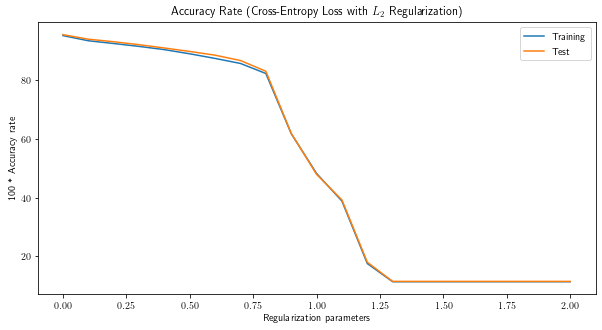

In [126]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Cross-Entropy Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params2, train_acc_L2, label="Training")
plt.plot(reg_params2, test_acc_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

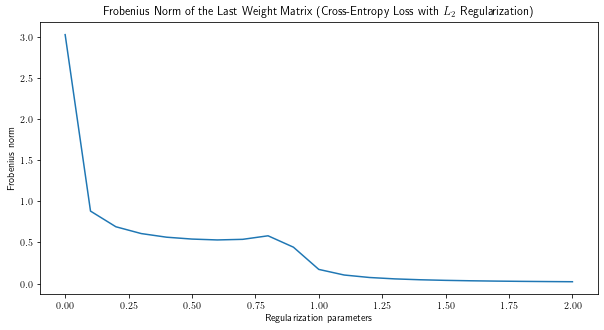

In [127]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Frobenius Norm of the Last Weight Matrix (Cross-Entropy Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params2, matrix_norm_L2)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

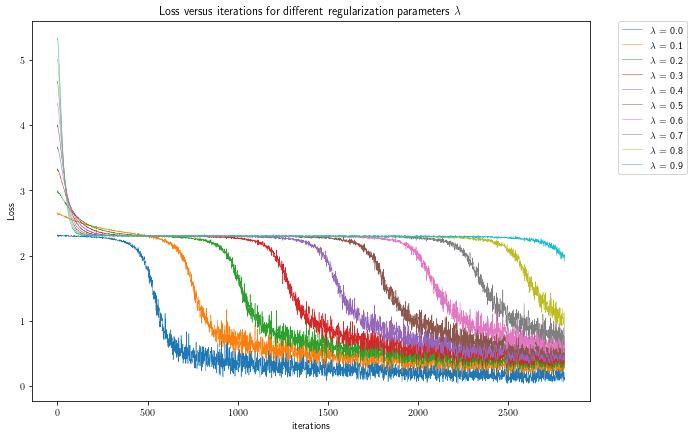

In [177]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_L2)-11):
    plt.plot(listoflist_L2[i], label=r"$\lambda$ = {:.1f}".format(reg_params2[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

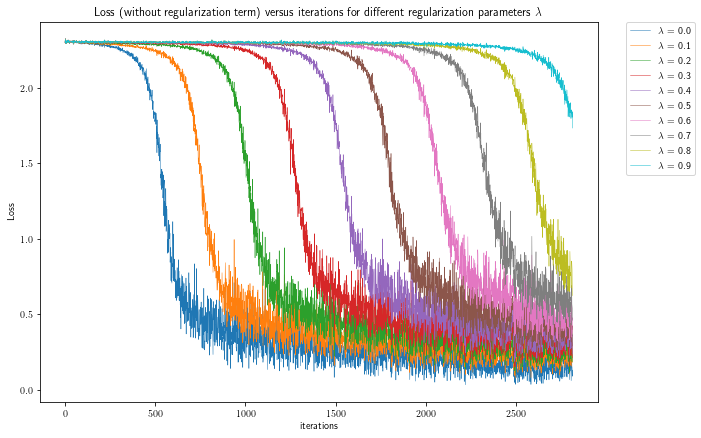

In [178]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_nr_L2)-11):
    plt.plot(listoflist_nr_L2[i], label=r"$\lambda$ = {:.1f}".format(reg_params2[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Dropout

In [40]:
#create an array of dropout probability from 0 to 0.9 by 0.1
dropout_prob_CE = np.linspace(0, 0.9, num=10, endpoint=True)

#initiate a list storing training average loss for different dropout prob
train_ave_loss_drop = []

#initiate a list storing test average loss for different dropout prob
test_ave_loss_drop = []

#initiate a list storing training accuracy for different dropout prob
train_acc_drop = []

#initiate a list storing test accuracy for different dropout prob
test_acc_drop = []

#initiate a list storing matrix norm for different dropout prob
matrix_norm_drop = []

#initiate a list of lists tracking the training loss for different dropout prob
listoflist_drop = []

In [41]:
for dp in dropout_prob_CE:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Dropout(p=dp),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute loss
            loss = F.cross_entropy(output, target)
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Dropout probability: {:.1f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    dp, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_CELoss(trainset_loader)
    result_test = result_CELoss(testset_loader)
    train_ave_loss_drop.append(result_train[0])
    test_ave_loss_drop.append(result_test[0])
    train_acc_drop.append(result_train[1])
    test_acc_drop.append(result_test[1])
    matrix_norm_drop.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_drop.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Dropout probability: 0.0 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297990
Dropout probability: 0.0 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.294003
Dropout probability: 0.0 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.284033
Dropout probability: 0.0 Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.252434
Dropout probability: 0.0 Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.161397
Dropout probability: 0.0 Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.837699
Dropout probability: 0.0 Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.030526
Dropout probability: 0.0 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.404566
Dropout probability: 0.0 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.228524
Dropout probability: 0.0 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.421691
30.09s
Dropout probability: 0.0 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.325630
Dropout probability: 0.0 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.279891
Dropout probability: 0.0 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.479350
Dropout probability: 0.0 T

Dropout probability: 0.3 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.340159
Dropout probability: 0.3 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.078245
Dropout probability: 0.3 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.219044
Dropout probability: 0.3 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.203720
Dropout probability: 0.3 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.074364
Dropout probability: 0.3 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.355151
Dropout probability: 0.3 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.367505
Dropout probability: 0.3 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.284951
Dropout probability: 0.3 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.311110
31.79s

Test set: Average loss: 0.1365, Accuracy: 9592/10000 (96%)

Dropout probability: 0.4 Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296502
Dropout probability: 0.4 Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.293876
Dropout probability: 0.4 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.285000
Dropout probability: 0.4 Train Epoch: 1

29.58s
Dropout probability: 0.7 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.482066
Dropout probability: 0.7 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.564764
Dropout probability: 0.7 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.547485
Dropout probability: 0.7 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.375205
Dropout probability: 0.7 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.316387
Dropout probability: 0.7 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.331551
Dropout probability: 0.7 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.379030
Dropout probability: 0.7 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.474943
Dropout probability: 0.7 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.195600
28.54s
Dropout probability: 0.7 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.214864
Dropout probability: 0.7 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.381722
Dropout probability: 0.7 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.161580
Dropout probability: 0.7 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.352283
Dropout probabil

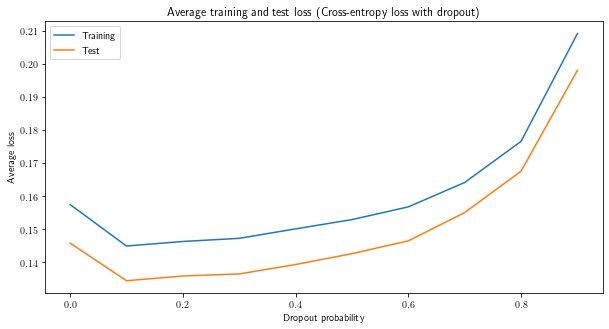

In [42]:
#plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average training and test loss (Cross-entropy loss with dropout)")
plt.plot(dropout_prob_CE, train_ave_loss_drop, label="Training")
plt.plot(dropout_prob_CE, test_ave_loss_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("Average loss")
plt.legend()
plt.show()

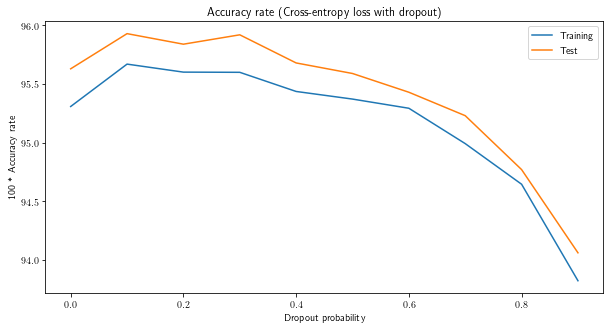

In [43]:
#plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy rate (Cross-entropy loss with dropout)")
plt.plot(dropout_prob_CE, train_acc_drop, label="Training")
plt.plot(dropout_prob_CE, test_acc_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

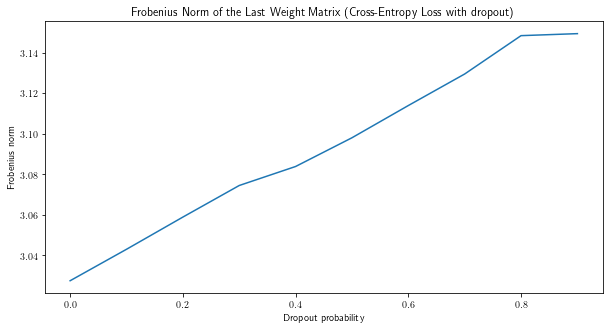

In [44]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (Cross-Entropy Loss with dropout)")
plt.plot(dropout_prob_CE, matrix_norm_drop)
plt.xlabel("Dropout probability")
plt.ylabel("Frobenius norm")
plt.show()

# 2. Hinge Loss

## $L_1$ regularization on the last layer

In [136]:
#create an array of regularization parameters from 0 to 5 with step size 0.25
reg_params_hinge_L1 = np.linspace(0, 0.3, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_hinge_L1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_hinge_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_hinge_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_hinge_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_hinge_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_hinge_L1 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_hinge_nr_L1 = []

In [137]:
#define the hinge loss function
def hinge_loss(output, target):
    output_y = output[torch.arange(0,target.size(0)).long(), target.data].view(-1,1)
    loss = output - output_y + 1
    loss[torch.arange(0, target.size(0)).long(), target.data] = 0
    loss[loss<0]=0
    
    return torch.sum(loss)

In [138]:
#define a function to compute average loss and accuracy rate
def result_hinge(loader):
    model.eval()
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            sum_loss += hinge_loss(output, target)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return (sum_loss/len(loader.dataset)), (100. * correct / len(loader.dataset)), correct, len(loader.dataset) 

In [139]:
for reg_param in reg_params_hinge_L1:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (w/o reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #compute loss
            loss = hinge_loss(output, target)/target.size(0) + reg_param*l1_norm
            a_list.append(loss.item())
            b_list.append((hinge_loss(output, target)/target.size(0)).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_hinge_L1.append(result_train[0])
    test_ave_loss_hinge_L1.append(result_test[0])
    train_acc_hinge_L1.append(result_train[1])
    test_acc_hinge_L1.append(result_test[1])
    matrix_norm_hinge_L1.append(torch.norm(model.fc_layers[-1].weight.detach(), p=1))
    listoflist_hinge_L1.append(list(a_list))
    listoflist_hinge_nr_L1.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.941230
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.842637
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.626338
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.417917
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110297
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.340325
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.502273
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.211092
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.029912
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.236884
29.49s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.145943
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.174191
Regularization pa

Regularization parameter: 0.030 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.468975
Regularization parameter: 0.030 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.817417
Regularization parameter: 0.030 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.488392
Regularization parameter: 0.030 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.445477
Regularization parameter: 0.030 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.561635
Regularization parameter: 0.030 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.533308
Regularization parameter: 0.030 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.350219
Regularization parameter: 0.030 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.488457
26.23s
Regularization parameter: 0.030 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.398701
Regularization parameter: 0.030 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.651082
Regularization parameter: 0.030 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.339261
Regularization parameter: 0.030 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.344844
Regularizati

Regularization parameter: 0.060 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.337984
Regularization parameter: 0.060 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.301447
Regularization parameter: 0.060 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.275777
Regularization parameter: 0.060 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.407487
Regularization parameter: 0.060 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.304523
Regularization parameter: 0.060 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.566767
Regularization parameter: 0.060 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.553561
27.18s

Test set: Average loss: 0.1734, Accuracy: 9567/10000 (96%)

Regularization parameter: 0.070 Train Epoch: 1 [0/60000 (0%)]	Loss: 15.058991
Regularization parameter: 0.070 Train Epoch: 1 [6400/60000 (11%)]	Loss: 8.046992
Regularization parameter: 0.070 Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.058660
Regularization parameter: 0.070 Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.325901
Regularization parameter: 0.070 Tra

Regularization parameter: 0.100 Train Epoch: 1 [19200/60000 (32%)]	Loss: 3.299274
Regularization parameter: 0.100 Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.457176
Regularization parameter: 0.100 Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.498395
Regularization parameter: 0.100 Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.751483
Regularization parameter: 0.100 Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.102195
Regularization parameter: 0.100 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.768384
Regularization parameter: 0.100 Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.019198
33.54s
Regularization parameter: 0.100 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.804427
Regularization parameter: 0.100 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.610658
Regularization parameter: 0.100 Train Epoch: 2 [16768/60000 (28%)]	Loss: 1.192444
Regularization parameter: 0.100 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.743601
Regularization parameter: 0.100 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.572420
Regularizat

Regularization parameter: 0.130 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.718059
Regularization parameter: 0.130 Train Epoch: 2 [35968/60000 (60%)]	Loss: 1.268131
Regularization parameter: 0.130 Train Epoch: 2 [42368/60000 (71%)]	Loss: 1.026968
Regularization parameter: 0.130 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.641228
Regularization parameter: 0.130 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.944699
26.45s
Regularization parameter: 0.130 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.735933
Regularization parameter: 0.130 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.888050
Regularization parameter: 0.130 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.632329
Regularization parameter: 0.130 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.586202
Regularization parameter: 0.130 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.614522
Regularization parameter: 0.130 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.498930
Regularization parameter: 0.130 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.695548
Regularizati

Regularization parameter: 0.160 Train Epoch: 3 [39936/60000 (67%)]	Loss: 1.078076
Regularization parameter: 0.160 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.688558
Regularization parameter: 0.160 Train Epoch: 3 [52736/60000 (88%)]	Loss: 1.020596
Regularization parameter: 0.160 Train Epoch: 3 [59136/60000 (99%)]	Loss: 1.094371
26.66s

Test set: Average loss: 0.3486, Accuracy: 9219/10000 (92%)

Regularization parameter: 0.170 Train Epoch: 1 [0/60000 (0%)]	Loss: 23.798651
Regularization parameter: 0.170 Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.089931
Regularization parameter: 0.170 Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.913419
Regularization parameter: 0.170 Train Epoch: 1 [19200/60000 (32%)]	Loss: 9.160736
Regularization parameter: 0.170 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.845281
Regularization parameter: 0.170 Train Epoch: 1 [32000/60000 (53%)]	Loss: 9.059505
Regularization parameter: 0.170 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.493342
Regularization parameter: 0.170 Tra

Regularization parameter: 0.200 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.531431
Regularization parameter: 0.200 Train Epoch: 1 [44800/60000 (75%)]	Loss: 9.028808
Regularization parameter: 0.200 Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.073536
Regularization parameter: 0.200 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.872568
27.63s
Regularization parameter: 0.200 Train Epoch: 2 [3968/60000 (7%)]	Loss: 8.882010
Regularization parameter: 0.200 Train Epoch: 2 [10368/60000 (17%)]	Loss: 9.441935
Regularization parameter: 0.200 Train Epoch: 2 [16768/60000 (28%)]	Loss: 9.136996
Regularization parameter: 0.200 Train Epoch: 2 [23168/60000 (39%)]	Loss: 8.524096
Regularization parameter: 0.200 Train Epoch: 2 [29568/60000 (49%)]	Loss: 9.923155
Regularization parameter: 0.200 Train Epoch: 2 [35968/60000 (60%)]	Loss: 9.782575
Regularization parameter: 0.200 Train Epoch: 2 [42368/60000 (71%)]	Loss: 9.674353
Regularization parameter: 0.200 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.670959
Regularizat

Regularization parameter: 0.230 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.712031
Regularization parameter: 0.230 Train Epoch: 2 [55168/60000 (92%)]	Loss: 9.491161
26.44s
Regularization parameter: 0.230 Train Epoch: 3 [1536/60000 (3%)]	Loss: 8.957568
Regularization parameter: 0.230 Train Epoch: 3 [7936/60000 (13%)]	Loss: 9.166401
Regularization parameter: 0.230 Train Epoch: 3 [14336/60000 (24%)]	Loss: 8.230827
Regularization parameter: 0.230 Train Epoch: 3 [20736/60000 (35%)]	Loss: 9.013459
Regularization parameter: 0.230 Train Epoch: 3 [27136/60000 (45%)]	Loss: 8.862585
Regularization parameter: 0.230 Train Epoch: 3 [33536/60000 (56%)]	Loss: 9.311064
Regularization parameter: 0.230 Train Epoch: 3 [39936/60000 (67%)]	Loss: 9.609810
Regularization parameter: 0.230 Train Epoch: 3 [46336/60000 (77%)]	Loss: 9.903828
Regularization parameter: 0.230 Train Epoch: 3 [52736/60000 (88%)]	Loss: 9.071973
Regularization parameter: 0.230 Train Epoch: 3 [59136/60000 (99%)]	Loss: 8.662182
27.10s

Test

Regularization parameter: 0.260 Train Epoch: 3 [59136/60000 (99%)]	Loss: 8.724295
26.65s

Test set: Average loss: 8.8204, Accuracy: 1135/10000 (11%)

Regularization parameter: 0.270 Train Epoch: 1 [0/60000 (0%)]	Loss: 32.538311
Regularization parameter: 0.270 Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.252915
Regularization parameter: 0.270 Train Epoch: 1 [12800/60000 (21%)]	Loss: 9.076539
Regularization parameter: 0.270 Train Epoch: 1 [19200/60000 (32%)]	Loss: 9.323294
Regularization parameter: 0.270 Train Epoch: 1 [25600/60000 (43%)]	Loss: 9.000410
Regularization parameter: 0.270 Train Epoch: 1 [32000/60000 (53%)]	Loss: 9.221050
Regularization parameter: 0.270 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.651492
Regularization parameter: 0.270 Train Epoch: 1 [44800/60000 (75%)]	Loss: 9.144048
Regularization parameter: 0.270 Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.190379
Regularization parameter: 0.270 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.990800
26.51s
Regularization parameter: 0.

Regularization parameter: 0.300 Train Epoch: 1 [57600/60000 (96%)]	Loss: 9.059068
29.05s
Regularization parameter: 0.300 Train Epoch: 2 [3968/60000 (7%)]	Loss: 9.063405
Regularization parameter: 0.300 Train Epoch: 2 [10368/60000 (17%)]	Loss: 9.616749
Regularization parameter: 0.300 Train Epoch: 2 [16768/60000 (28%)]	Loss: 9.316939
Regularization parameter: 0.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 8.696529
Regularization parameter: 0.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 10.099817
Regularization parameter: 0.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 9.959252
Regularization parameter: 0.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 9.861923
Regularization parameter: 0.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.851094
Regularization parameter: 0.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 9.627902
28.02s
Regularization parameter: 0.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 9.101459
Regularization parameter: 0.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 9.298079
Regula

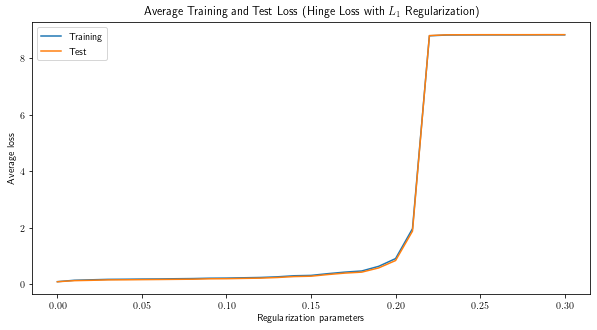

In [140]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L1, train_ave_loss_hinge_L1, label="Training")
plt.plot(reg_params_hinge_L1, test_ave_loss_hinge_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

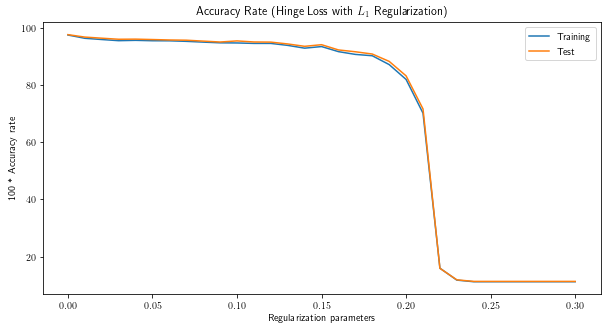

In [141]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L1, train_acc_hinge_L1, label="Training")
plt.plot(reg_params_hinge_L1, test_acc_hinge_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

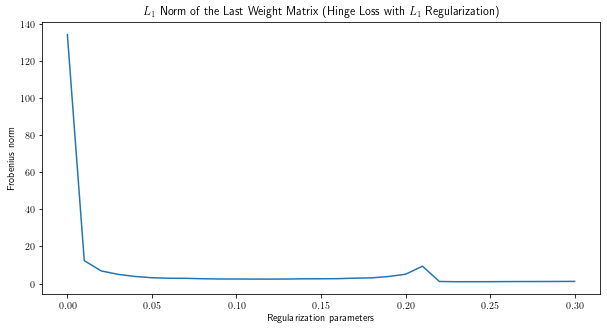

In [142]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"$L_1$ Norm of the Last Weight Matrix (Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L1, matrix_norm_hinge_L1)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

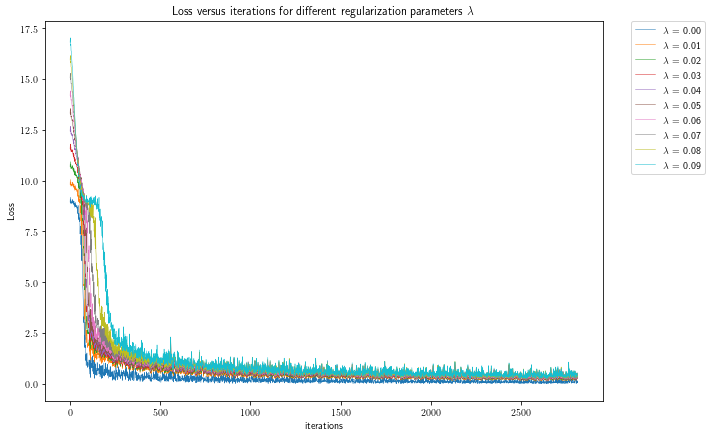

In [179]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_hinge_L1)-21):
    plt.plot(listoflist_hinge_L1[i], label=r"$\lambda$ = {:.2f}".format(reg_params_hinge_L1[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

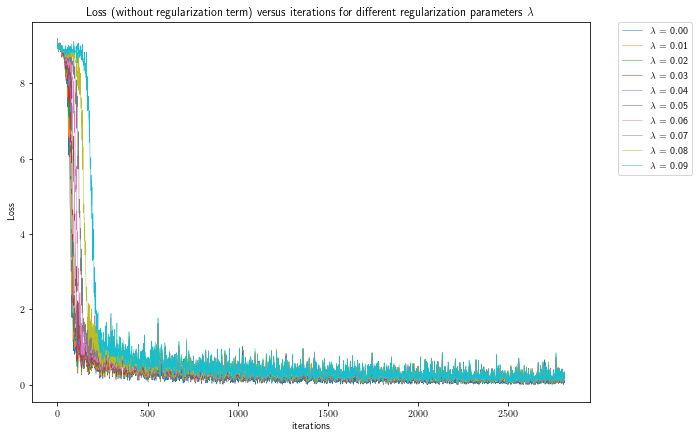

In [180]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_hinge_nr_L1)-21):
    plt.plot(listoflist_hinge_nr_L1[i], label=r"$\lambda$ = {:.2f}".format(reg_params_hinge_L1[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## $L_2$ regularization on the last layer:

In [159]:
#create an array of regularization parameters from 0 to 150 with step size 5
reg_params_hinge_L2 = np.linspace(0, 150, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_hinge_L2 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_hinge_L2 = []

#initiate a list storing training accuracy for different reg_param
train_acc_hinge_L2 = []

#initiate a list storing test accuracy for different reg_param
test_acc_hinge_L2 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_hinge_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_hinge_L2 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_hinge_nr_L2 = []

In [160]:
for reg_param in reg_params_hinge_L2:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (w/o reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L2 norm of weight matrix on the last layer 
            l2_norm = torch.norm(model.fc_layers[-1].weight)**2
            
            #compute loss
            loss = hinge_loss(output, target)/target.size(0) + reg_param*l2_norm
            a_list.append(loss.item())
            b_list.append((hinge_loss(output, target)/target.size(0)).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_hinge_L2.append(result_train[0])
    test_ave_loss_hinge_L2.append(result_test[0])
    train_acc_hinge_L2.append(result_train[1])
    test_acc_hinge_L2.append(result_test[1])
    matrix_norm_hinge_L2.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_hinge_L2.append(list(a_list))
    listoflist_hinge_nr_L2.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.941230
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.842637
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.626338
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.417917
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110297
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.340325
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.502273
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.211092
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.029912
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.236884
30.53s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.145943
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.174191
Regularization pa

26.59s
Regularization parameter: 15.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 1.667679
Regularization parameter: 15.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 1.733288
Regularization parameter: 15.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.281941
Regularization parameter: 15.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 1.453016
Regularization parameter: 15.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 1.052829
Regularization parameter: 15.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 1.465382
Regularization parameter: 15.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 1.631725
Regularization parameter: 15.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 1.525913
Regularization parameter: 15.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 1.721123
32.74s
Regularization parameter: 15.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 1.394519
Regularization parameter: 15.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.261328
Regularization parameter: 15.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 1.31

Regularization parameter: 30.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.403078
Regularization parameter: 30.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.926264
Regularization parameter: 30.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 1.970060
Regularization parameter: 30.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 2.438095
Regularization parameter: 30.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 1.688534
Regularization parameter: 30.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 1.211527
Regularization parameter: 30.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.060187
Regularization parameter: 30.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 1.195638
Regularization parameter: 30.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 2.681372
Regularization parameter: 30.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 1.812516
26.33s

Test set: Average loss: 0.7483, Accuracy: 8805/10000 (88%)

Regularization parameter: 35.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 126.651382
Regularization parameter:

26.28s

Test set: Average loss: 1.0071, Accuracy: 7760/10000 (78%)

Regularization parameter: 50.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 177.098587
Regularization parameter: 50.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 8.973404
Regularization parameter: 50.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.804584
Regularization parameter: 50.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 9.050394
Regularization parameter: 50.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.734160
Regularization parameter: 50.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.950361
Regularization parameter: 50.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.383433
Regularization parameter: 50.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 8.869506
Regularization parameter: 50.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.915017
Regularization parameter: 50.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.720643
26.46s
Regularization parameter: 50.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 8.721877
Regularization par

Regularization parameter: 65.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.723630
26.20s
Regularization parameter: 65.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 8.730858
Regularization parameter: 65.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 9.287749
Regularization parameter: 65.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 8.981012
Regularization parameter: 65.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 8.389332
Regularization parameter: 65.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 9.763821
Regularization parameter: 65.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 9.658614
Regularization parameter: 65.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 9.528797
Regularization parameter: 65.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.480322
Regularization parameter: 65.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 9.491815
26.36s
Regularization parameter: 65.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 8.894437
Regularization parameter: 65.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 6.71

26.58s
Regularization parameter: 80.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 8.764292
Regularization parameter: 80.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 8.965150
Regularization parameter: 80.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 8.087942
Regularization parameter: 80.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 9.012905
Regularization parameter: 80.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 8.331749
Regularization parameter: 80.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 7.533429
Regularization parameter: 80.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 8.237328
Regularization parameter: 80.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 4.961750
Regularization parameter: 80.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 4.922320
Regularization parameter: 80.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 4.666183
26.79s

Test set: Average loss: 2.2348, Accuracy: 5965/10000 (60%)

Regularization parameter: 85.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 294.808746
Regularization par

27.91s

Test set: Average loss: 8.2868, Accuracy: 1686/10000 (17%)

Regularization parameter: 100.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 345.255951
Regularization parameter: 100.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 8.973654
Regularization parameter: 100.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.802914
Regularization parameter: 100.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 9.051759
Regularization parameter: 100.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.732298
Regularization parameter: 100.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.948417
Regularization parameter: 100.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.382022
Regularization parameter: 100.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 8.875285
Regularization parameter: 100.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.919017
Regularization parameter: 100.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.722803
25.97s
Regularization parameter: 100.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 8.730024
Regular

Regularization parameter: 115.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.920300
Regularization parameter: 115.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.721898
26.36s
Regularization parameter: 115.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 8.731165
Regularization parameter: 115.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 9.289929
Regularization parameter: 115.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 8.984744
Regularization parameter: 115.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 8.370955
Regularization parameter: 115.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 9.773232
Regularization parameter: 115.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 9.627452
Regularization parameter: 115.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 9.518530
Regularization parameter: 115.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.510140
Regularization parameter: 115.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 9.293156
26.62s
Regularization parameter: 115.000 Train Epoch: 3 [1536/60000 (3%

Regularization parameter: 130.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 9.518941
Regularization parameter: 130.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 9.511470
Regularization parameter: 130.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 9.292980
26.35s
Regularization parameter: 130.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 8.760565
Regularization parameter: 130.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 8.964624
Regularization parameter: 130.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 8.030588
Regularization parameter: 130.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 8.815788
Regularization parameter: 130.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 8.661294
Regularization parameter: 130.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 9.107952
Regularization parameter: 130.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 9.400610
Regularization parameter: 130.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 9.691513
Regularization parameter: 130.000 Train Epoch: 3 [52736/60000 (88%)]	Los

Regularization parameter: 145.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 9.110957
Regularization parameter: 145.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 9.395929
Regularization parameter: 145.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 9.693563
Regularization parameter: 145.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 8.857516
Regularization parameter: 145.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 8.460360
28.00s

Test set: Average loss: 8.8212, Accuracy: 1135/10000 (11%)

Regularization parameter: 150.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 513.413330
Regularization parameter: 150.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 8.983870
Regularization parameter: 150.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 8.801603
Regularization parameter: 150.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 9.050752
Regularization parameter: 150.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.733263
Regularization parameter: 150.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.949202
Regularizati

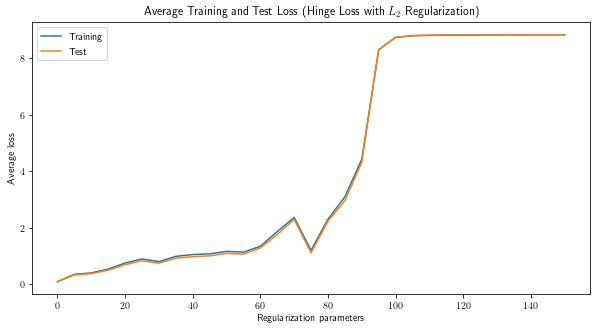

In [161]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L2, train_ave_loss_hinge_L2, label="Training")
plt.plot(reg_params_hinge_L2, test_ave_loss_hinge_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

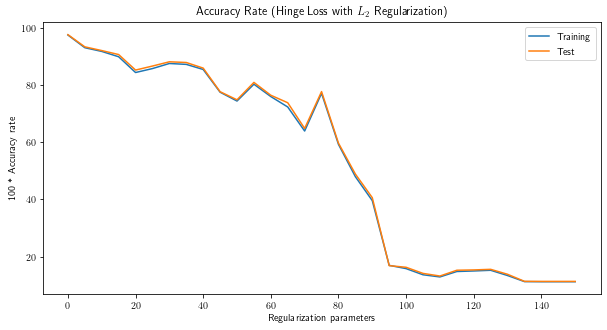

In [162]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L2, train_acc_hinge_L2, label="Training")
plt.plot(reg_params_hinge_L2, test_acc_hinge_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

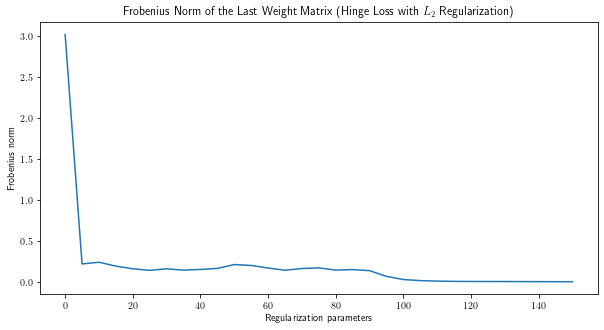

In [163]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Frobenius Norm of the Last Weight Matrix (Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_hinge_L2, matrix_norm_hinge_L2)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

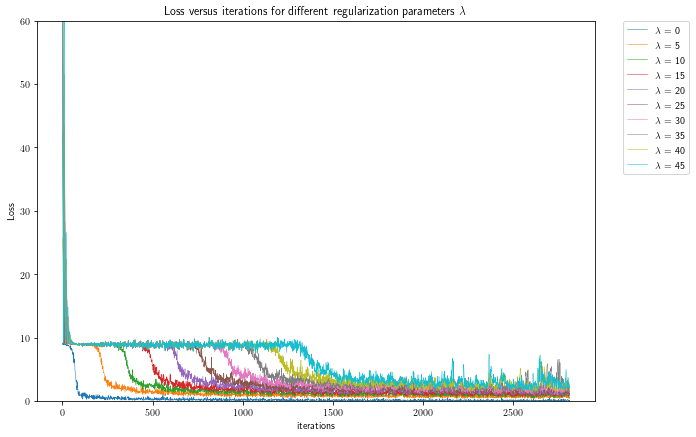

In [181]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_hinge_L2)-21):
    plt.plot(listoflist_hinge_L2[i], label=r"$\lambda$ = {:.0f}".format(reg_params_hinge_L2[i]), linewidth=0.5)

plt.ylim(0, 60) 
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

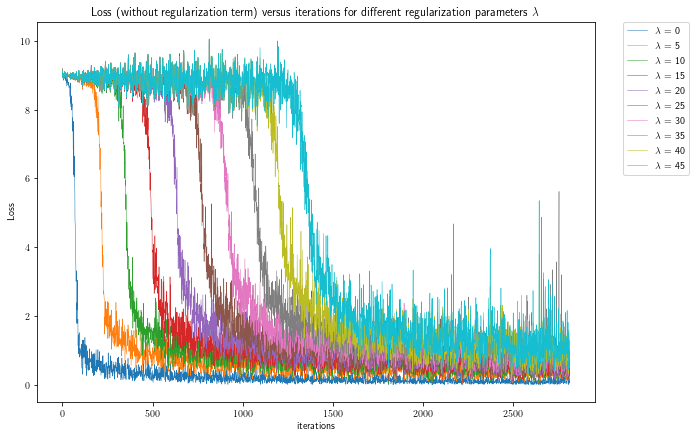

In [182]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_hinge_nr_L2)-21):
    plt.plot(listoflist_hinge_nr_L2[i], label=r"$\lambda$ = {:.0f}".format(reg_params_hinge_L2[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Dropout

In [29]:
#create an array of dropout probability from 0 to 0.9 by 0.1
dropout_prob_hinge = np.linspace(0, 0.9, num=10, endpoint=True)

#initiate a list storing training average loss for different dropout prob
train_ave_loss_hinge_drop = []

#initiate a list storing test average loss for different dropout prob
test_ave_loss_hinge_drop = []

#initiate a list storing training accuracy for different dropout prob
train_acc_hinge_drop = []

#initiate a list storing test accuracy for different dropout prob
test_acc_hinge_drop = []

#initiate a list storing matrix norm for different dropout prob
matrix_norm_hinge_drop = []

#initiate a list of lists tracking the training loss for different dropout prob
listoflist_hinge_drop = []

In [30]:
for dp in dropout_prob_hinge:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Dropout(p=dp),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute loss
            loss = hinge_loss(output, target)/target.size(0)
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Dropout probability: {:.1f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    dp, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_hinge(trainset_loader)
    result_test = result_hinge(testset_loader)
    train_ave_loss_hinge_drop.append(result_train[0])
    test_ave_loss_hinge_drop.append(result_test[0])
    train_acc_hinge_drop.append(result_train[1])
    test_acc_hinge_drop.append(result_test[1])
    matrix_norm_hinge_drop.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_hinge_drop.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Dropout probability: 0.0 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.941230
Dropout probability: 0.0 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.842637
Dropout probability: 0.0 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.626338
Dropout probability: 0.0 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.417917
Dropout probability: 0.0 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.110297
Dropout probability: 0.0 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.340325
Dropout probability: 0.0 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.502273
Dropout probability: 0.0 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.211092
Dropout probability: 0.0 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.029912
Dropout probability: 0.0 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.236884
29.87s
Dropout probability: 0.0 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.145943
Dropout probability: 0.0 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.174191
Dropout probability: 0.0 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.352105
Dropout probability: 0.0 T

Dropout probability: 0.3 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.246398
Dropout probability: 0.3 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.030549
Dropout probability: 0.3 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.179077
Dropout probability: 0.3 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.049535
Dropout probability: 0.3 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.019720
Dropout probability: 0.3 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.202479
Dropout probability: 0.3 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.263843
Dropout probability: 0.3 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.174113
Dropout probability: 0.3 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.303752
28.83s

Test set: Average loss: 0.0848, Accuracy: 9759/10000 (98%)

Dropout probability: 0.4 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.925207
Dropout probability: 0.4 Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.180491
Dropout probability: 0.4 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.882765
Dropout probability: 0.4 Train Epoch: 1

25.95s
Dropout probability: 0.7 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.306872
Dropout probability: 0.7 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.561808
Dropout probability: 0.7 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.470067
Dropout probability: 0.7 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.259173
Dropout probability: 0.7 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.233276
Dropout probability: 0.7 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.185418
Dropout probability: 0.7 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.201144
Dropout probability: 0.7 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.383473
Dropout probability: 0.7 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.090687
25.70s
Dropout probability: 0.7 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.083276
Dropout probability: 0.7 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.210845
Dropout probability: 0.7 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.059499
Dropout probability: 0.7 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.295229
Dropout probabil

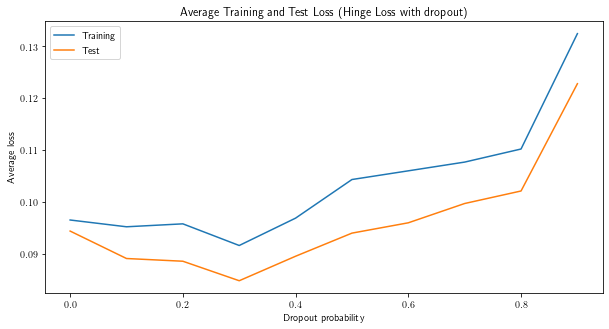

In [31]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (Hinge Loss with dropout)")
plt.plot(dropout_prob_hinge, train_ave_loss_hinge_drop, label="Training")
plt.plot(dropout_prob_hinge, test_ave_loss_hinge_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("Average loss")
plt.legend()
plt.show()

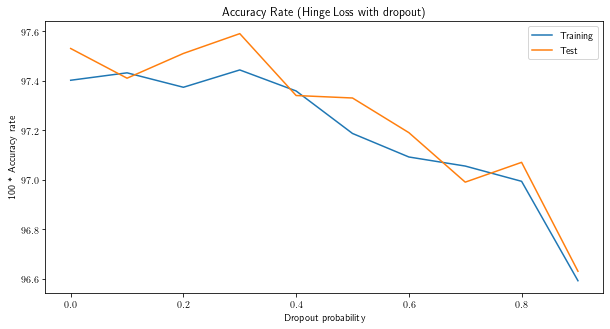

In [32]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (Hinge Loss with dropout)")
plt.plot(dropout_prob_hinge, train_acc_hinge_drop, label="Training")
plt.plot(dropout_prob_hinge, test_acc_hinge_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

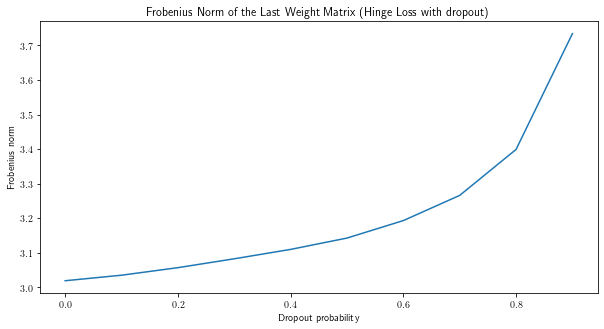

In [33]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (Hinge Loss with dropout)")
plt.plot(dropout_prob_hinge, matrix_norm_hinge_drop)
plt.xlabel("Dropout probability")
plt.ylabel("Frobenius norm")
plt.show()

# Squared hinge loss

## $L_1$ regularization on the last layer

In [13]:
#define the squared hinge loss function
def sqhinge_loss(output, target):
    output_y = output[torch.arange(0,target.size(0)).long(), target.data].view(-1,1)
    loss = output - output_y + 1
    loss[torch.arange(0, target.size(0)).long(), target.data] = 0
    loss[loss<0]=0
    
    return torch.sum(loss**2)

In [14]:
#define a function to compute average loss and accuracy rate
def result_sqhinge(loader):
    model.eval()
    sum_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            sum_loss += sqhinge_loss(output, target)
            correct += pred.eq(target.view_as(pred)).sum().item()
    return (sum_loss/len(loader.dataset)), (100. * correct / len(loader.dataset)), correct, len(loader.dataset) 

In [15]:
#create an array of regularization parameters from 0 to 3 with step size 0.1
reg_params_sqhinge_L1 = np.linspace(0, 3, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_sqhinge_L1 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_sqhinge_L1 = []

#initiate a list storing training accuracy for different reg_param
train_acc_sqhinge_L1 = []

#initiate a list storing test accuracy for different reg_param
test_acc_sqhinge_L1 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_sqhinge_L1 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_sqhinge_L1 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_sqhinge_nr_L1 = []

In [16]:
for reg_param in reg_params_sqhinge_L1:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (w/o reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L1 norm of weight matrix on the last layer 
            l1_norm = torch.norm(model.fc_layers[-1].weight, p=1)
            
            #compute loss
            loss = sqhinge_loss(output, target)/target.size(0) + reg_param*l1_norm
            a_list.append(loss.item())
            b_list.append((sqhinge_loss(output, target)/target.size(0)).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_sqhinge(trainset_loader)
    result_test = result_sqhinge(testset_loader)
    train_ave_loss_sqhinge_L1.append(result_train[0])
    test_ave_loss_sqhinge_L1.append(result_test[0])
    train_acc_sqhinge_L1.append(result_train[1])
    test_acc_sqhinge_L1.append(result_test[1])
    matrix_norm_sqhinge_L1.append(torch.norm(model.fc_layers[-1].weight.detach(), p=1))
    listoflist_sqhinge_L1.append(list(a_list))
    listoflist_sqhinge_nr_L1.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.931667
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.592236
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.539611
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.325542
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073478
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317288
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.376682
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169009
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.027529
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124372
31.75s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089459
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.221514
Regularization pa

Regularization parameter: 0.300 Train Epoch: 2 [10368/60000 (17%)]	Loss: 1.168486
Regularization parameter: 0.300 Train Epoch: 2 [16768/60000 (28%)]	Loss: 1.894899
Regularization parameter: 0.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 1.303148
Regularization parameter: 0.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 1.134494
Regularization parameter: 0.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 1.419991
Regularization parameter: 0.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 1.289438
Regularization parameter: 0.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 1.001875
Regularization parameter: 0.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 1.242396
27.44s
Regularization parameter: 0.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 1.169851
Regularization parameter: 0.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.343463
Regularization parameter: 0.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 1.044584
Regularization parameter: 0.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 1.129253
Regularizati

Regularization parameter: 0.600 Train Epoch: 3 [20736/60000 (35%)]	Loss: 2.638565
Regularization parameter: 0.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 2.761808
Regularization parameter: 0.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 2.312724
Regularization parameter: 0.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.729238
Regularization parameter: 0.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 2.381984
Regularization parameter: 0.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 2.809105
Regularization parameter: 0.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.954363
29.42s

Test set: Average loss: 0.3423, Accuracy: 9495/10000 (95%)

Regularization parameter: 0.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 70.109283
Regularization parameter: 0.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 10.893259
Regularization parameter: 0.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 10.830912
Regularization parameter: 0.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 10.763354
Regularization parameter: 0.700 

Regularization parameter: 1.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 12.575411
Regularization parameter: 1.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 12.480753
Regularization parameter: 1.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 12.563593
Regularization parameter: 1.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 12.743017
Regularization parameter: 1.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 12.687469
Regularization parameter: 1.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 12.580614
Regularization parameter: 1.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 12.705303
27.44s
Regularization parameter: 1.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 12.586674
Regularization parameter: 1.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 12.650274
Regularization parameter: 1.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 12.708441
Regularization parameter: 1.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 12.828605
Regularization parameter: 1.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 12.491604

Regularization parameter: 1.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 15.367385
Regularization parameter: 1.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 15.330709
Regularization parameter: 1.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 15.708391
Regularization parameter: 1.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 15.614452
Regularization parameter: 1.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 10.847325
Regularization parameter: 1.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 10.985806
28.42s
Regularization parameter: 1.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 10.377707
Regularization parameter: 1.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 9.149529
Regularization parameter: 1.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 8.616128
Regularization parameter: 1.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 9.387394
Regularization parameter: 1.300 Train Epoch: 3 [27136/60000 (45%)]	Loss: 9.049898
Regularization parameter: 1.300 Train Epoch: 3 [33536/60000 (56%)]	Loss: 7.762662
Regul

Regularization parameter: 1.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 11.979345
Regularization parameter: 1.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 11.266427
Regularization parameter: 1.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 13.378321
Regularization parameter: 1.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 11.040460
Regularization parameter: 1.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 11.440288
Regularization parameter: 1.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 12.428556
29.33s

Test set: Average loss: 0.6948, Accuracy: 9020/10000 (90%)

Regularization parameter: 1.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 157.505875
Regularization parameter: 1.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 19.781567
Regularization parameter: 1.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 19.168972
Regularization parameter: 1.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 19.440260
Regularization parameter: 1.700 Train Epoch: 1 [25600/60000 (43%)]	Loss: 19.153725
Regularization parameter

Regularization parameter: 2.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 23.241707
Regularization parameter: 2.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 22.919014
Regularization parameter: 2.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 23.071007
Regularization parameter: 2.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 23.370728
Regularization parameter: 2.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 23.019066
Regularization parameter: 2.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 22.948502
Regularization parameter: 2.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 22.978367
27.86s
Regularization parameter: 2.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 22.951490
Regularization parameter: 2.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 22.951971
Regularization parameter: 2.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 22.717476
Regularization parameter: 2.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 23.409630
Regularization parameter: 2.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 23.369392

Regularization parameter: 2.300 Train Epoch: 2 [23168/60000 (39%)]	Loss: 27.674671
Regularization parameter: 2.300 Train Epoch: 2 [29568/60000 (49%)]	Loss: 27.537567
Regularization parameter: 2.300 Train Epoch: 2 [35968/60000 (60%)]	Loss: 27.618813
Regularization parameter: 2.300 Train Epoch: 2 [42368/60000 (71%)]	Loss: 27.485241
Regularization parameter: 2.300 Train Epoch: 2 [48768/60000 (81%)]	Loss: 27.722717
Regularization parameter: 2.300 Train Epoch: 2 [55168/60000 (92%)]	Loss: 27.972336
29.34s
Regularization parameter: 2.300 Train Epoch: 3 [1536/60000 (3%)]	Loss: 27.538393
Regularization parameter: 2.300 Train Epoch: 3 [7936/60000 (13%)]	Loss: 28.193134
Regularization parameter: 2.300 Train Epoch: 3 [14336/60000 (24%)]	Loss: 28.160042
Regularization parameter: 2.300 Train Epoch: 3 [20736/60000 (35%)]	Loss: 29.496487
Regularization parameter: 2.300 Train Epoch: 3 [27136/60000 (45%)]	Loss: 26.515203
Regularization parameter: 2.300 Train Epoch: 3 [33536/60000 (56%)]	Loss: 22.816605


Regularization parameter: 2.600 Train Epoch: 3 [27136/60000 (45%)]	Loss: 33.448605
Regularization parameter: 2.600 Train Epoch: 3 [33536/60000 (56%)]	Loss: 33.215004
Regularization parameter: 2.600 Train Epoch: 3 [39936/60000 (67%)]	Loss: 33.942001
Regularization parameter: 2.600 Train Epoch: 3 [46336/60000 (77%)]	Loss: 32.996712
Regularization parameter: 2.600 Train Epoch: 3 [52736/60000 (88%)]	Loss: 35.057240
Regularization parameter: 2.600 Train Epoch: 3 [59136/60000 (99%)]	Loss: 30.845913
27.01s

Test set: Average loss: 2.9965, Accuracy: 5671/10000 (57%)

Regularization parameter: 2.700 Train Epoch: 1 [0/60000 (0%)]	Loss: 244.902466
Regularization parameter: 2.700 Train Epoch: 1 [6400/60000 (11%)]	Loss: 34.860317
Regularization parameter: 2.700 Train Epoch: 1 [12800/60000 (21%)]	Loss: 34.353336
Regularization parameter: 2.700 Train Epoch: 1 [19200/60000 (32%)]	Loss: 34.658882
Regularization parameter: 2.700 Train Epoch: 1 [25600/60000 (43%)]	Loss: 33.728931
Regularization parameter

Regularization parameter: 3.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 39.774986
Regularization parameter: 3.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 39.660530
Regularization parameter: 3.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 40.357346
Regularization parameter: 3.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 39.720543
Regularization parameter: 3.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 39.862877
Regularization parameter: 3.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 40.484268
Regularization parameter: 3.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 39.626404
27.07s
Regularization parameter: 3.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 39.930962
Regularization parameter: 3.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 39.777351
Regularization parameter: 3.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 39.146431
Regularization parameter: 3.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 39.808365
Regularization parameter: 3.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 39.593033

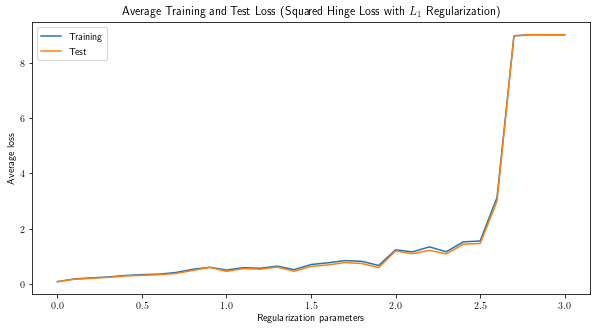

In [17]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Squared Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L1, train_ave_loss_sqhinge_L1, label="Training")
plt.plot(reg_params_sqhinge_L1, test_ave_loss_sqhinge_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

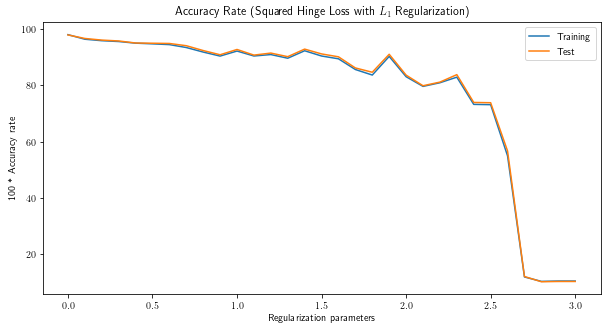

In [18]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Squared Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L1, train_acc_sqhinge_L1, label="Training")
plt.plot(reg_params_sqhinge_L1, test_acc_sqhinge_L1, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

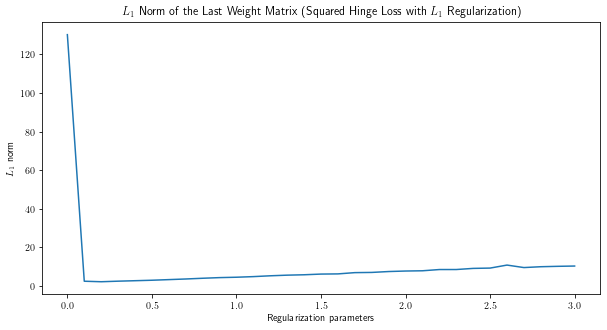

In [19]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"$L_1$ Norm of the Last Weight Matrix (Squared Hinge Loss with "
          r"$L_1$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L1, matrix_norm_sqhinge_L1)
plt.xlabel("Regularization parameters")
plt.ylabel(r"$L_1$ norm")
plt.show()

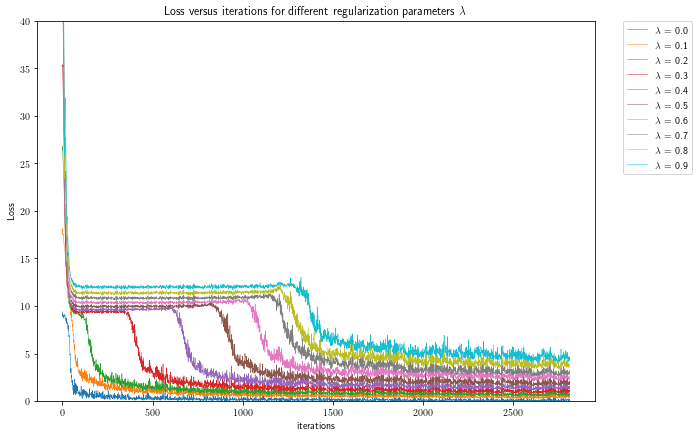

In [23]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_sqhinge_L1)-21):
    plt.plot(listoflist_sqhinge_L1[i], label=r"$\lambda$ = {:.1f}".format(reg_params_sqhinge_L1[i]), linewidth=0.5)

plt.ylim(0, 40)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

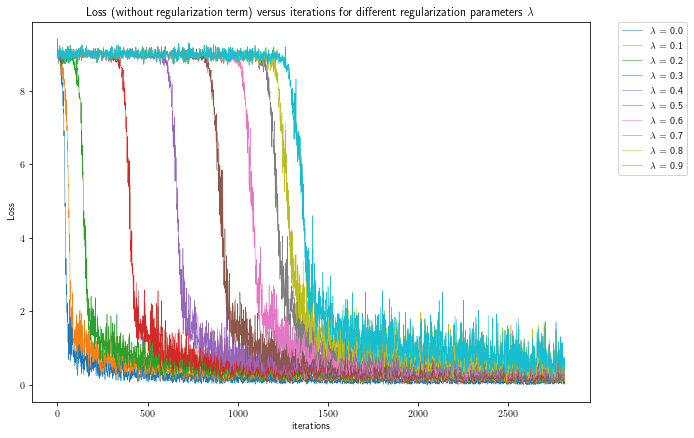

In [24]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_sqhinge_nr_L1)-21):
    plt.plot(listoflist_sqhinge_nr_L1[i], label=r"$\lambda$ = {:.1f}".format(reg_params_sqhinge_L1[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## $L_2$ regularization on the last layer

In [26]:
#create an array of regularization parameters from 0 to 3 with step size 0.1
reg_params_sqhinge_L2 = np.linspace(0, 150, num=31, endpoint=True)

#initiate a list storing training average loss for different reg_param
train_ave_loss_sqhinge_L2 = []

#initiate a list storing test average loss for different reg_param
test_ave_loss_sqhinge_L2 = []

#initiate a list storing training accuracy for different reg_param
train_acc_sqhinge_L2 = []

#initiate a list storing test accuracy for different reg_param
test_acc_sqhinge_L2 = []

#initiate a list storing matrix norm for different reg_param
matrix_norm_sqhinge_L2 = []

#initiate a list of lists tracking the training loss for different reg_param
listoflist_sqhinge_L2 = []

#initiate a list of lists tracking the training loss(without reg term)
listoflist_sqhinge_nr_L2 = []

In [27]:
for reg_param in reg_params_sqhinge_L2:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    b_list = [] #tracking the loss function value (w/o reg-term)
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute the L2 norm of weight matrix on the last layer 
            l2_norm = torch.norm(model.fc_layers[-1].weight)**2
            
            #compute loss
            loss = sqhinge_loss(output, target)/target.size(0) + reg_param*l2_norm
            a_list.append(loss.item())
            b_list.append((sqhinge_loss(output, target)/target.size(0)).item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Regularization parameter: {:.3f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    reg_param, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_sqhinge(trainset_loader)
    result_test = result_sqhinge(testset_loader)
    train_ave_loss_sqhinge_L2.append(result_train[0])
    test_ave_loss_sqhinge_L2.append(result_test[0])
    train_acc_sqhinge_L2.append(result_train[1])
    test_acc_sqhinge_L2.append(result_test[1])
    matrix_norm_sqhinge_L2.append(torch.norm(model.fc_layers[-1].weight.detach()))
    listoflist_sqhinge_L2.append(list(a_list))
    listoflist_sqhinge_nr_L2.append(list(b_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Regularization parameter: 0.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.931667
Regularization parameter: 0.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.592236
Regularization parameter: 0.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.539611
Regularization parameter: 0.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.325542
Regularization parameter: 0.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073478
Regularization parameter: 0.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317288
Regularization parameter: 0.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.376682
Regularization parameter: 0.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169009
Regularization parameter: 0.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.027529
Regularization parameter: 0.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124372
42.06s
Regularization parameter: 0.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089459
Regularization parameter: 0.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.221514
Regularization pa

26.24s
Regularization parameter: 15.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 1.490648
Regularization parameter: 15.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 1.376919
Regularization parameter: 15.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 2.159253
Regularization parameter: 15.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 1.215072
Regularization parameter: 15.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 1.221586
Regularization parameter: 15.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 1.148146
Regularization parameter: 15.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 1.899629
Regularization parameter: 15.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 1.468199
Regularization parameter: 15.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 1.401709
29.33s
Regularization parameter: 15.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 1.504790
Regularization parameter: 15.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.539713
Regularization parameter: 15.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 1.10

Regularization parameter: 30.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 2.266783
Regularization parameter: 30.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 1.924969
Regularization parameter: 30.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 2.137981
Regularization parameter: 30.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 1.737170
Regularization parameter: 30.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 1.334305
Regularization parameter: 30.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 1.459527
Regularization parameter: 30.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 2.864127
Regularization parameter: 30.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 1.471128
Regularization parameter: 30.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 1.699695
Regularization parameter: 30.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 2.335546
26.89s

Test set: Average loss: 0.5358, Accuracy: 9356/10000 (94%)

Regularization parameter: 35.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 126.641815
Regularization parameter:

26.37s

Test set: Average loss: 2.3630, Accuracy: 8340/10000 (83%)

Regularization parameter: 50.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 177.089035
Regularization parameter: 50.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.025669
Regularization parameter: 50.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 9.057365
Regularization parameter: 50.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.999611
Regularization parameter: 50.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.810499
Regularization parameter: 50.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 5.483574
Regularization parameter: 50.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 4.906724
Regularization parameter: 50.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 3.799818
Regularization parameter: 50.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.286891
Regularization parameter: 50.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 4.077329
26.02s
Regularization parameter: 50.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 4.031024
Regularization par

Regularization parameter: 65.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 5.000605
28.33s
Regularization parameter: 65.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 5.686496
Regularization parameter: 65.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 3.174802
Regularization parameter: 65.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 5.216117
Regularization parameter: 65.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 3.004870
Regularization parameter: 65.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 3.984061
Regularization parameter: 65.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 4.177861
Regularization parameter: 65.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 5.808981
Regularization parameter: 65.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 3.214325
Regularization parameter: 65.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 5.483988
26.90s
Regularization parameter: 65.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 3.155586
Regularization parameter: 65.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 3.80

Regularization parameter: 80.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 4.007858
26.31s
Regularization parameter: 80.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 3.580185
Regularization parameter: 80.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 3.395035
Regularization parameter: 80.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 5.196917
Regularization parameter: 80.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 5.709246
Regularization parameter: 80.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 5.199006
Regularization parameter: 80.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 3.281594
Regularization parameter: 80.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 4.082528
Regularization parameter: 80.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 3.951262
Regularization parameter: 80.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 5.099905
Regularization parameter: 80.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 5.311459
26.43s

Test set: Average loss: 1.3698, Accuracy: 8451/10000 (85%)

Regularization 

Regularization parameter: 95.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 5.594644
Regularization parameter: 95.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 7.916761
28.01s

Test set: Average loss: 1.8119, Accuracy: 8279/10000 (83%)

Regularization parameter: 100.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 345.246399
Regularization parameter: 100.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.026834
Regularization parameter: 100.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 9.043677
Regularization parameter: 100.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.996532
Regularization parameter: 100.000 Train Epoch: 1 [25600/60000 (43%)]	Loss: 8.896979
Regularization parameter: 100.000 Train Epoch: 1 [32000/60000 (53%)]	Loss: 8.968721
Regularization parameter: 100.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.110350
Regularization parameter: 100.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 9.148621
Regularization parameter: 100.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 8.940421
Regularization

Regularization parameter: 115.000 Train Epoch: 1 [38400/60000 (64%)]	Loss: 9.105469
Regularization parameter: 115.000 Train Epoch: 1 [44800/60000 (75%)]	Loss: 9.078178
Regularization parameter: 115.000 Train Epoch: 1 [51200/60000 (85%)]	Loss: 9.055608
Regularization parameter: 115.000 Train Epoch: 1 [57600/60000 (96%)]	Loss: 8.770175
27.24s
Regularization parameter: 115.000 Train Epoch: 2 [3968/60000 (7%)]	Loss: 7.846705
Regularization parameter: 115.000 Train Epoch: 2 [10368/60000 (17%)]	Loss: 6.606240
Regularization parameter: 115.000 Train Epoch: 2 [16768/60000 (28%)]	Loss: 7.252454
Regularization parameter: 115.000 Train Epoch: 2 [23168/60000 (39%)]	Loss: 5.526759
Regularization parameter: 115.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 6.054991
Regularization parameter: 115.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 6.231331
Regularization parameter: 115.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 6.455699
Regularization parameter: 115.000 Train Epoch: 2 [48768/60000 (81%)]	Lo

Regularization parameter: 130.000 Train Epoch: 2 [29568/60000 (49%)]	Loss: 6.694040
Regularization parameter: 130.000 Train Epoch: 2 [35968/60000 (60%)]	Loss: 7.062504
Regularization parameter: 130.000 Train Epoch: 2 [42368/60000 (71%)]	Loss: 6.152304
Regularization parameter: 130.000 Train Epoch: 2 [48768/60000 (81%)]	Loss: 11.811401
Regularization parameter: 130.000 Train Epoch: 2 [55168/60000 (92%)]	Loss: 8.065116
27.14s
Regularization parameter: 130.000 Train Epoch: 3 [1536/60000 (3%)]	Loss: 6.228987
Regularization parameter: 130.000 Train Epoch: 3 [7936/60000 (13%)]	Loss: 11.035057
Regularization parameter: 130.000 Train Epoch: 3 [14336/60000 (24%)]	Loss: 6.999188
Regularization parameter: 130.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 6.271831
Regularization parameter: 130.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 8.565924
Regularization parameter: 130.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 5.419282
Regularization parameter: 130.000 Train Epoch: 3 [39936/60000 (67%)]	L

Regularization parameter: 145.000 Train Epoch: 3 [20736/60000 (35%)]	Loss: 6.058494
Regularization parameter: 145.000 Train Epoch: 3 [27136/60000 (45%)]	Loss: 8.191897
Regularization parameter: 145.000 Train Epoch: 3 [33536/60000 (56%)]	Loss: 7.560325
Regularization parameter: 145.000 Train Epoch: 3 [39936/60000 (67%)]	Loss: 11.193423
Regularization parameter: 145.000 Train Epoch: 3 [46336/60000 (77%)]	Loss: 5.484962
Regularization parameter: 145.000 Train Epoch: 3 [52736/60000 (88%)]	Loss: 7.381124
Regularization parameter: 145.000 Train Epoch: 3 [59136/60000 (99%)]	Loss: 6.383107
28.94s

Test set: Average loss: 3.4627, Accuracy: 5839/10000 (58%)

Regularization parameter: 150.000 Train Epoch: 1 [0/60000 (0%)]	Loss: 513.403748
Regularization parameter: 150.000 Train Epoch: 1 [6400/60000 (11%)]	Loss: 9.040058
Regularization parameter: 150.000 Train Epoch: 1 [12800/60000 (21%)]	Loss: 9.038827
Regularization parameter: 150.000 Train Epoch: 1 [19200/60000 (32%)]	Loss: 8.989650
Regularizat

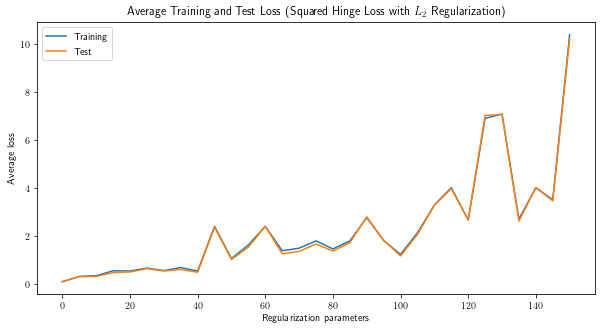

In [28]:
plt.rc('text', usetex=True)

#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Average Training and Test Loss (Squared Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L2, train_ave_loss_sqhinge_L2, label="Training")
plt.plot(reg_params_sqhinge_L2, test_ave_loss_sqhinge_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("Average loss")
plt.legend()
plt.show()

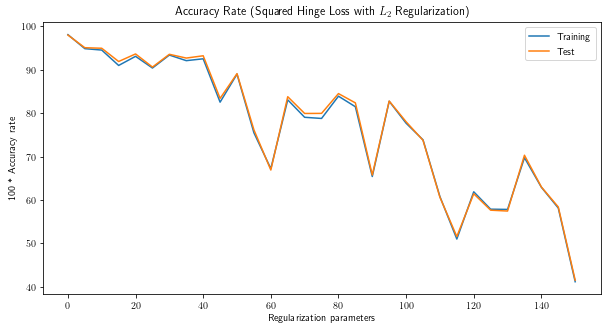

In [29]:
plt.rc('text', usetex=True)

#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Accuracy Rate (Squared Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L2, train_acc_sqhinge_L2, label="Training")
plt.plot(reg_params_sqhinge_L2, test_acc_sqhinge_L2, label="Test")
plt.xlabel("Regularization parameters")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

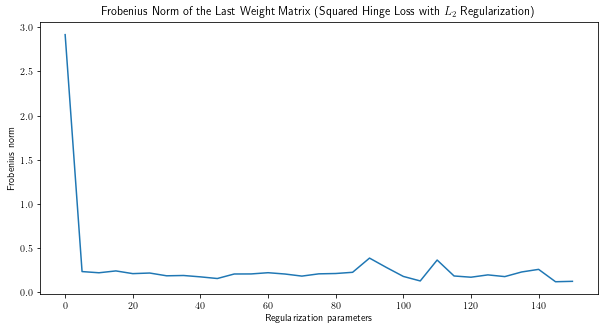

In [30]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title(r"Frobenius Norm of the Last Weight Matrix (Squared Hinge Loss with "
          r"$L_2$ "
          r"Regularization)")
plt.plot(reg_params_sqhinge_L2, matrix_norm_sqhinge_L2)
plt.xlabel("Regularization parameters")
plt.ylabel("Frobenius norm")
plt.show()

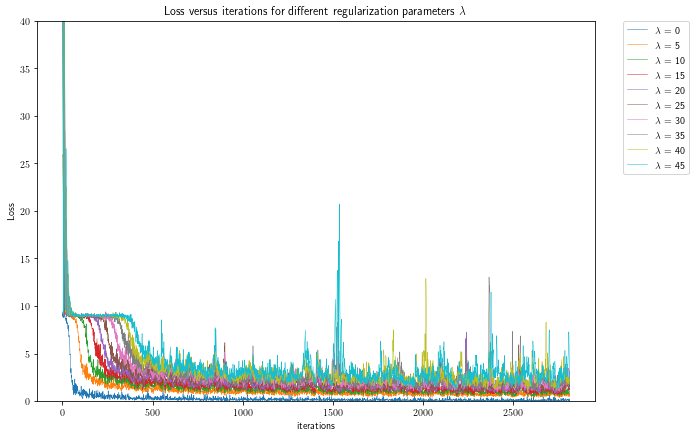

In [32]:
plt.figure(figsize=(10,7))
plt.title(r"Loss versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_sqhinge_L2)-21):
    plt.plot(listoflist_sqhinge_L2[i], label=r"$\lambda$ = {:.0f}".format(reg_params_sqhinge_L2[i]), linewidth=0.5)

plt.ylim(0, 40)
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

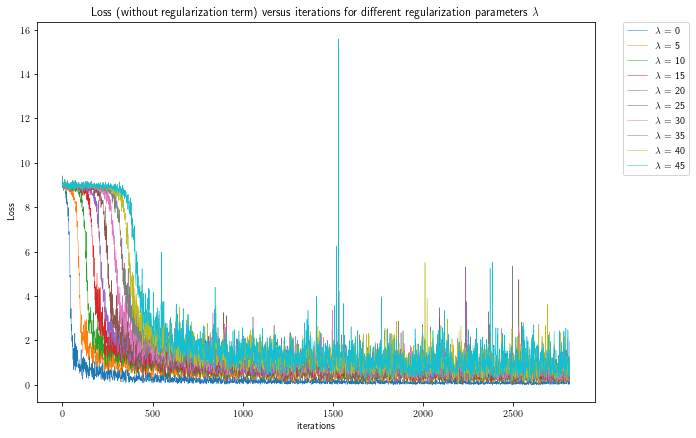

In [33]:
plt.figure(figsize=(10,7))
plt.title(r"Loss (without regularization term) versus iterations for different regularization parameters "
          r"$\lambda$")
for i in range(len(listoflist_sqhinge_nr_L2)-21):
    plt.plot(listoflist_sqhinge_nr_L2[i], label=r"$\lambda$ = {:.0f}".format(reg_params_sqhinge_L2[i]), linewidth=0.5)

plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Dropout

In [35]:
#create an array of dropout probability from 0 to 0.9 by 0.1
dropout_prob_sqhinge = np.linspace(0, 0.9, num=10, endpoint=True)

#initiate a list storing training average loss for different dropout prob
train_ave_loss_sqhinge_drop = []

#initiate a list storing test average loss for different dropout prob
test_ave_loss_sqhinge_drop = []

#initiate a list storing training accuracy for different dropout prob
train_acc_sqhinge_drop = []

#initiate a list storing test accuracy for different dropout prob
test_acc_sqhinge_drop = []

#initiate a list storing matrix norm for different dropout prob
matrix_norm_sqhinge_drop = []

#initiate a list of lists tracking the training loss for different dropout prob
listoflist_sqhinge_drop = []

In [36]:
for dp in dropout_prob_sqhinge:
    class NetSeq(nn.Module):
        def __init__(self):
            super(NetSeq, self).__init__()
            
            #set seed
            random.seed(100)
            torch.manual_seed(100)

            # conv layers: feature extractor
            self.conv_layers = nn.Sequential(
                nn.Conv2d(1, 10, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU(),
                nn.Conv2d(10, 20, kernel_size=5),
                nn.MaxPool2d(2),
                nn.ReLU()
            )
        
            # fc layers: classifier
            self.fc_layers = nn.Sequential(
                nn.Linear(320, 300),
                nn.ReLU(),
                nn.Dropout(p=dp),
                nn.Linear(300, 10),
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = x.view(-1, 320)
            x = self.fc_layers(x)
            return x

    model = NetSeq().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    model.train() #training mode
    iteration = 0
    a_list = [] #tracking the loss function value
    for ep in range(epoch):
        start = time()
        for batch_idx, (data, target) in enumerate(trainset_loader):
            data, target = data.to(device), target.to(device)
            
            #forward pass
            output = model(data)
            
            #compute loss
            loss = sqhinge_loss(output, target)/target.size(0)
            a_list.append(loss.item())
            
            #backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if iteration % 100 == 0:
                print('Dropout probability: {:.1f} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    dp, ep+1, batch_idx * len(data), len(trainset_loader.dataset),
                    100. * batch_idx / len(trainset_loader), loss.item()))
            iteration += 1
        end = time()
        print('{:.2f}s'.format(end-start))
    
    result_train = result_sqhinge(trainset_loader)
    result_test = result_sqhinge(testset_loader)
    train_ave_loss_sqhinge_drop.append(result_train[0])
    test_ave_loss_sqhinge_drop.append(result_test[0])
    train_acc_sqhinge_drop.append(result_train[1])
    test_acc_sqhinge_drop.append(result_test[1])
    matrix_norm_sqhinge_drop.append(np.linalg.norm(model.fc_layers[-1].weight.detach().numpy()))
    listoflist_sqhinge_drop.append(list(a_list))
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        result_test[0], result_test[2], result_test[3],
        result_test[1]))

Dropout probability: 0.0 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.931667
Dropout probability: 0.0 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.592236
Dropout probability: 0.0 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.539611
Dropout probability: 0.0 Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.325542
Dropout probability: 0.0 Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.073478
Dropout probability: 0.0 Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.317288
Dropout probability: 0.0 Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.376682
Dropout probability: 0.0 Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.169009
Dropout probability: 0.0 Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.027529
Dropout probability: 0.0 Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.124372
33.12s
Dropout probability: 0.0 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.089459
Dropout probability: 0.0 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.221514
Dropout probability: 0.0 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.283409
Dropout probability: 0.0 T

Dropout probability: 0.3 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.294185
Dropout probability: 0.3 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.043521
Dropout probability: 0.3 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.277023
Dropout probability: 0.3 Train Epoch: 3 [27136/60000 (45%)]	Loss: 0.085107
Dropout probability: 0.3 Train Epoch: 3 [33536/60000 (56%)]	Loss: 0.018009
Dropout probability: 0.3 Train Epoch: 3 [39936/60000 (67%)]	Loss: 0.197004
Dropout probability: 0.3 Train Epoch: 3 [46336/60000 (77%)]	Loss: 0.240968
Dropout probability: 0.3 Train Epoch: 3 [52736/60000 (88%)]	Loss: 0.164884
Dropout probability: 0.3 Train Epoch: 3 [59136/60000 (99%)]	Loss: 0.205913
26.11s

Test set: Average loss: 0.0868, Accuracy: 9805/10000 (98%)

Dropout probability: 0.4 Train Epoch: 1 [0/60000 (0%)]	Loss: 8.903243
Dropout probability: 0.4 Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.612890
Dropout probability: 0.4 Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.910995
Dropout probability: 0.4 Train Epoch: 1

26.49s
Dropout probability: 0.7 Train Epoch: 2 [3968/60000 (7%)]	Loss: 0.289760
Dropout probability: 0.7 Train Epoch: 2 [10368/60000 (17%)]	Loss: 0.525249
Dropout probability: 0.7 Train Epoch: 2 [16768/60000 (28%)]	Loss: 0.445901
Dropout probability: 0.7 Train Epoch: 2 [23168/60000 (39%)]	Loss: 0.416048
Dropout probability: 0.7 Train Epoch: 2 [29568/60000 (49%)]	Loss: 0.168023
Dropout probability: 0.7 Train Epoch: 2 [35968/60000 (60%)]	Loss: 0.261623
Dropout probability: 0.7 Train Epoch: 2 [42368/60000 (71%)]	Loss: 0.256015
Dropout probability: 0.7 Train Epoch: 2 [48768/60000 (81%)]	Loss: 0.243255
Dropout probability: 0.7 Train Epoch: 2 [55168/60000 (92%)]	Loss: 0.164812
26.15s
Dropout probability: 0.7 Train Epoch: 3 [1536/60000 (3%)]	Loss: 0.065977
Dropout probability: 0.7 Train Epoch: 3 [7936/60000 (13%)]	Loss: 0.193154
Dropout probability: 0.7 Train Epoch: 3 [14336/60000 (24%)]	Loss: 0.047274
Dropout probability: 0.7 Train Epoch: 3 [20736/60000 (35%)]	Loss: 0.351324
Dropout probabil

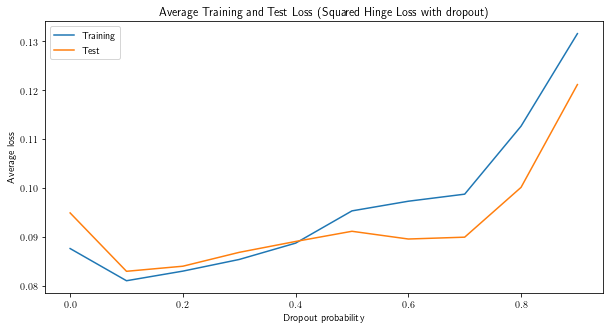

In [37]:
#plot average loss versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Average Training and Test Loss (Squared Hinge Loss with dropout)")
plt.plot(dropout_prob_sqhinge, train_ave_loss_sqhinge_drop, label="Training")
plt.plot(dropout_prob_sqhinge, test_ave_loss_sqhinge_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("Average loss")
plt.legend()
plt.show()

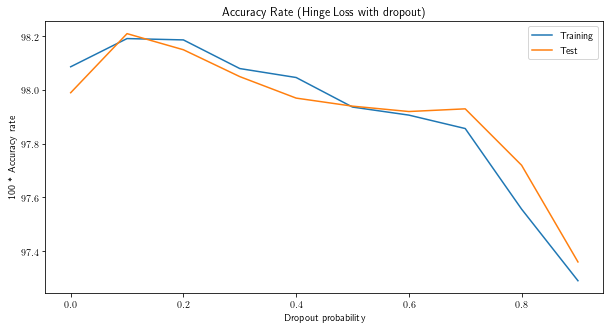

In [38]:
#plot accuracy rate versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Accuracy Rate (Hinge Loss with dropout)")
plt.plot(dropout_prob_sqhinge, train_acc_sqhinge_drop, label="Training")
plt.plot(dropout_prob_sqhinge, test_acc_sqhinge_drop, label="Test")
plt.xlabel("Dropout probability")
plt.ylabel("100 * Accuracy rate")
plt.legend()
plt.show()

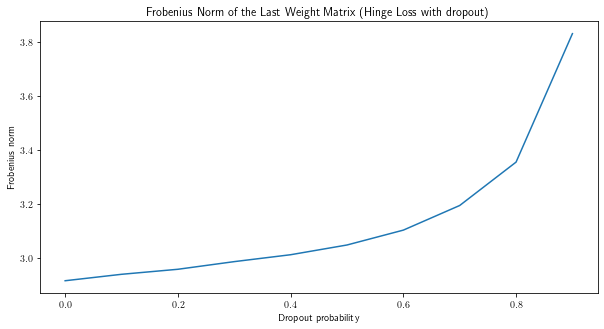

In [39]:
#plot the Frobenius norm of the last weight matrix versus regularization parameters
plt.figure(figsize=(10,5))
plt.title("Frobenius Norm of the Last Weight Matrix (Hinge Loss with dropout)")
plt.plot(dropout_prob_sqhinge, matrix_norm_sqhinge_drop)
plt.xlabel("Dropout probability")
plt.ylabel("Frobenius norm")
plt.show()